In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import h5py
from scipy.io import loadmat, savemat
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
%matplotlib inline

/home/joeldapello/anaconda3/envs/torch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def getWholeImages(impath):
    imgs = loadmat(impath)['img_mat'][0]
    prepped_imgs = []
    for i in range(imgs.shape[0]):
        img = Image.fromarray(imgs[i]).resize([227,227])
        rgb_img = Image.new("RGB", img.size)
        rgb_img.paste(img)
        prepped_imgs.append(np.array(rgb_img))
                                              
    prepped_imgs = np.array(prepped_imgs)
    prepped_imgs = np.transpose(prepped_imgs,(0,3,1,2))
    prepped_imgs = prepped_imgs/255 # normalize between 0-1
    return prepped_imgs

def getClasses(classPath):
    classes = loadmat(classPath)
    classes = np.squeeze(classes['data']['truth'][0,0])
    return classes

def getOccludedImgsByIdx(file, idx):
    dataset = file['dataset']
    imstack_ref = dataset[0,idx]
    imstack = np.transpose(file[imstack_ref],(3,0,1,2))/255
    return imstack

def polarize(tensor):
    new_tensor = tensor.copy()
    new_tensor[tensor>0]=1
    new_tensor[tensor==0]=-1
    new_tensor[tensor<0]=-1
    return new_tensor

In [7]:
__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# define original alexnet
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.fc7 = None

    # modify forward to spit out softmax, fc7, and pool 5 for convenience
    def forward(self, x):
        x = self.features(x)
        p5 = x.view(x.size(0), 256 * 6 * 6)
        fc7 = self.fc7(p5)
        return {"p5" : p5, "fc7" : fc7}


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model

# get pretrained alexnet
model = alexnet(pretrained=True)

# get rid of dropout layers; they make results of forward stochastic.
sel = [1,2,4,5,6]
model.classifier = nn.Sequential(*[list(model.classifier.children())[i] for i in sel])

# define fc7 pass
sel = [0,1,2]
model.fc7 = nn.Sequential(*[list(model.classifier.children())[i] for i in sel])
model.children

<bound method Module.children of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=4096, out_features=4096, bias=Tr

In [6]:
X.shape

torch.Size([325, 3, 227, 227])

In [8]:
## run whole images through, extracting fc7 represenations
impath = '../imageData/fullImages_325.mat'
X = getWholeImages(impath)
X = torch.tensor(X).float()
out = model.forward(X)
fc7_full = out['fc7'].detach().numpy()
fc7_object_id = np.arange(len(fc7_full))

In [9]:
fc7_full.shape

(325, 4096)

In [10]:
occludedImgFile = h5py.File('../imageData/occludedImgs_13000.mat', 'r')

1

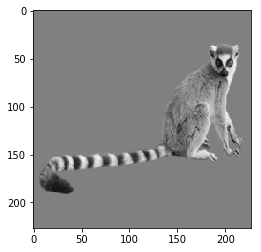

In [74]:
i = 40
# plt.imshow(np.transpose(getOccludedImgsByIdx(occludedImgFile,i)[10],(1,2,0)))
plt.imshow(np.transpose(X[i],(1,2,0)))
imstack_i = getOccludedImgsByIdx(occludedImgFile,i)
imstack_i = torch.tensor(imstack_i[::2]).float()
classes[i]

In [43]:
occludedImgFile = h5py.File('../imageData/occludedImgs_13000.mat', 'r')
num_objs = occludedImgFile['dataset'].shape[1]

fc7_occ = []

for i in range(num_objs):
    imstack_i = getOccludedImgsByIdx(occludedImgFile,i)
    imstack_i = torch.tensor(imstack_i).float()
    out = model.forward(imstack_i)
    fc7_occ_i = out['fc7'].detach().numpy()
    fc7_occ.append(fc7_occ_i)
    
fc7_occ=np.array(fc7_occ)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [51]:
# convert feature values to 1,-1
fc7_full_polarized = polarize(fc7_full)
fc7_occ_polarized = np.array([polarize(i) for i in fc7_occ])
fc7_full_polarized.shape,fc7_occ_polarized[0].shape

((325, 4096), (42, 4096))

In [38]:
classPath = '../imageData/fullImages_325_labels.mat'
classes = getClasses(classPath)

In [52]:
fc7_full[0,:]

array([ -7.760828 ,  -6.3315372,  -3.5679567, ...,  -7.0624456,
       -10.358625 ,  -7.2115593], dtype=float32)

In [50]:
savemat('../featureData/fc7FullAndOccPol_325.mat', {
    'fc7_full':fc7_full,
    'fc7_occ':fc7_occ,
    'fc7_full_polarized':fc7_full_polarized,
    'fc7_occ_polarized':fc7_occ_polarized,
    'classes':classes
})

ugh, now run 'featureAttractors.m', which will generate the hopfield network and run fc7_test and tc7_test_occ for 256 timesteps, saving the results to 'fc7_hop_trajs.mat'